In [6]:
import pandas as pd

column_names = ['datetime', 'pH']  
ph_dataset = pd.read_csv('cyano_culture_datasets/07-11-2025 culture/ph_log_2025-07-11_10-32-07.csv', header=None, names=column_names)
ph_dataset['unixtime'] = pd.to_datetime(ph_dataset['datetime']).astype('int64') // 10**9

In [7]:
import pandas as pd

# Read a single DO file
column_names = ['datetime', 'dO'] 
do_dataset = pd.read_csv('cyano_culture_datasets/07-11-2025 culture/do_log_2025-07-11_10-32-10.csv', header=None, names=column_names)
do_dataset['unixtime'] = pd.to_datetime(do_dataset['datetime']).astype('int64') // 10**9

# Rename column to match expected output
do_dataset = do_dataset.rename(columns={'dO': 'Dissolved Oxygen (mg/L)'})

# Final dataset with expected structure
merged_do_dataset = do_dataset[['unixtime', 'datetime', 'Dissolved Oxygen (mg/L)']]


In [8]:
column_names = ['datetime', 'Temperature (C)']
temp_dataset = pd.read_csv('cyano_culture_datasets/07-11-2025 culture/temperature_log_2025-07-11_10-32-04.csv', header=None, names=column_names)
temp_dataset['unixtime'] = pd.to_datetime(temp_dataset['datetime']).astype('int64') // 10**9

In [9]:
column_names = ['datetime', 'red_intensity', 'blue_intensity', 'green_intensity', 'color_combined']  
color_dataset = pd.read_csv('cyano_culture_datasets/07-11-2025 culture/color_log_2025-07-11_10-32-01.txt', header=None, names=column_names)
color_dataset['unixtime'] = pd.to_datetime(color_dataset['datetime']).astype('int64') // 10**9

In [10]:
df_combined = pd.merge(
    merged_do_dataset, ph_dataset, on="unixtime", how="outer", suffixes=("_do", "_ph")
)
df_combined = pd.merge(df_combined, temp_dataset, on="unixtime", how="outer")
df_combined = pd.merge(df_combined, color_dataset, on="unixtime", how="outer")

df_combined = df_combined.sort_values(by="unixtime").reset_index(drop=True)
df_combined["datetime"] = (
    df_combined["datetime_do"]
    .combine_first(df_combined["datetime_ph"])
    .combine_first(df_combined["datetime_x"])
    .combine_first(df_combined["datetime_y"])
)

df_combined = df_combined.drop(
    columns=["datetime_do", "datetime_ph", "datetime_x", "datetime_y"]
)
desired_order = [
    'unixtime', 'datetime', 'Temperature (C)', 'pH', 'Dissolved Oxygen (mg/L)',
    'red_intensity', 'green_intensity', 'blue_intensity', 'color_combined'
]

df_combined = df_combined[desired_order]

In [11]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_combined['Dissolved Oxygen (mg/L)'].quantile(0.25)
Q3 = df_combined['Dissolved Oxygen (mg/L)'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define acceptable range for the data (going for 2.5*IQR below Q1 and above Q3)
lower_bound = Q1 - 2.5 * IQR
upper_bound = Q3 + 2.5 * IQR

original_len = len(df_combined) 
# Filter the dataframe to remove outliers in "Dissolved Oxygen"
df_combined = df_combined[
    (df_combined['Dissolved Oxygen (mg/L)'] >= lower_bound) & 
    (df_combined['Dissolved Oxygen (mg/L)'] <= upper_bound)
].copy()

print(f"Removed {original_len - len(df_combined)} outliers from 'Dissolved Oxygen'.")


Removed 1000 outliers from 'Dissolved Oxygen'.


In [12]:
# # ADDING A FILTER FOR THE TIME RANGE
# start_time = 1744741273  # Replace with your start time in Unix time
# end_time = 1745406765  # Replace with your end time in Unix time
# df_combined = df_combined[
#     (df_combined["unixtime"] >= start_time) & (df_combined["unixtime"] <= end_time)
# ]

In [13]:
# Convert the datetime column to actual datetime objects
df_combined['datetime'] = pd.to_datetime(df_combined['datetime'])

# Function to calculate light intensity
def get_light_intensity(dt):
    dt = pd.to_datetime(dt)
    hour = dt.hour
    return 400 
    #return 150 if 8 <= hour < 20 else 0

# Apply function to create new column
df_combined['Light Intensity (μmol photons m² s⁻¹)'] = df_combined['datetime'].apply(get_light_intensity)
df_combined


,unixtime,datetime,Temperature (C),pH,Dissolved Oxygen (mg/L),red_intensity,green_intensity,blue_intensity,color_combined,Light Intensity (μmol photons m² s⁻¹)
7,1752229933,2025-07-11 10:32:13.389447,10.74,7.058,5.15,NaN,NaN,NaN,NaN,400
8,1752229934,2025-07-11 10:32:14.375497,10.76,7.061,5.16,NaN,NaN,NaN,NaN,400
9,1752229935,2025-07-11 10:32:15.361106,10.77,7.061,5.15,NaN,NaN,NaN,NaN,400
10,1752229936,2025-07-11 10:32:16.347421,10.80,7.062,5.15,NaN,NaN,NaN,NaN,400
11,1752229937,2025-07-11 10:32:17.334223,10.81,7.062,5.15,23391.0,13482.0,18537.0,51829.0,400
...,...,...,...,...,...,...,...,...,...,...
1079289,1753265219,2025-07-23 10:06:59.995316,29.80,7.985,5.58,NaN,NaN,NaN,NaN,400
1079290,1753265220,2025-07-23 10:07:00.996280,29.80,7.985,5.57,NaN,NaN,NaN,NaN,400
1079291,1753265221,2025-07-23 10:07:01.980378,29.80,7.986,5.57,NaN,NaN,NaN,NaN,400
1079292,1753265222,2025-07-23 10:07:02.967889,29.80,7.987,5.56,NaN,NaN,NaN,NaN,400


In [14]:
# df_combined = df_combined[: -1480] # take off the final bit where the dissolved Oxygne spikes

In [15]:
df_combined.to_csv(
    'cyano_culture_datasets/06-03-2025 culture/combined_dataset.csv',
    index=False
)

In [16]:
import numpy as np
#I_0 = df_combined['red_intensity'].max()
I_0 = 37123.4
def calculate_od_from_red_intensity(red_intensity, I0 = I_0):
    if pd.isna(red_intensity):
        return np.nan
    # Replace with your actual formula. For example:
    if red_intensity <= 0: return np.nan
    return -np.log10(red_intensity / I0)

df_combined['Optical Density (620 nm - 750 nm)'] = df_combined['red_intensity'].apply(calculate_od_from_red_intensity)
df_combined



,unixtime,datetime,Temperature (C),pH,Dissolved Oxygen (mg/L),red_intensity,green_intensity,blue_intensity,color_combined,Light Intensity (μmol photons m² s⁻¹),Optical Density (620 nm - 750 nm)
7,1752229933,2025-07-11 10:32:13.389447,10.74,7.058,5.15,NaN,NaN,NaN,NaN,400,NaN
8,1752229934,2025-07-11 10:32:14.375497,10.76,7.061,5.16,NaN,NaN,NaN,NaN,400,NaN
9,1752229935,2025-07-11 10:32:15.361106,10.77,7.061,5.15,NaN,NaN,NaN,NaN,400,NaN
10,1752229936,2025-07-11 10:32:16.347421,10.80,7.062,5.15,NaN,NaN,NaN,NaN,400,NaN
11,1752229937,2025-07-11 10:32:17.334223,10.81,7.062,5.15,23391.0,13482.0,18537.0,51829.0,400,0.200599
...,...,...,...,...,...,...,...,...,...,...,...
1079289,1753265219,2025-07-23 10:06:59.995316,29.80,7.985,5.58,NaN,NaN,NaN,NaN,400,NaN
1079290,1753265220,2025-07-23 10:07:00.996280,29.80,7.985,5.57,NaN,NaN,NaN,NaN,400,NaN
1079291,1753265221,2025-07-23 10:07:01.980378,29.80,7.986,5.57,NaN,NaN,NaN,NaN,400,NaN
1079292,1753265222,2025-07-23 10:07:02.967889,29.80,7.987,5.56,NaN,NaN,NaN,NaN,400,NaN


# What's the data look like?

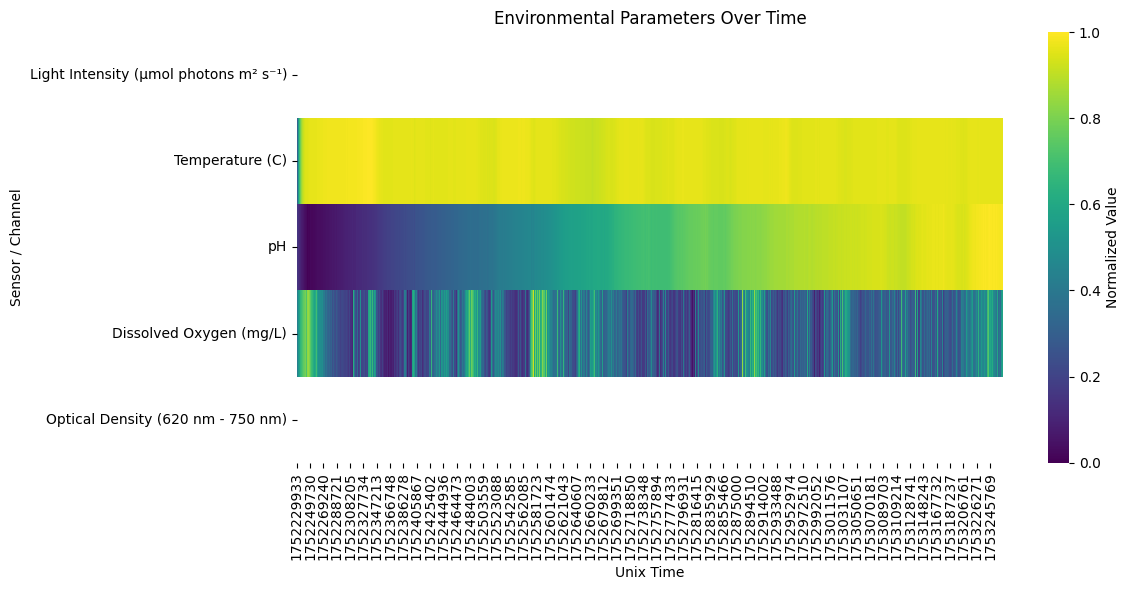

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = df_combined[
    [
        'unixtime',
        'Light Intensity (μmol photons m² s⁻¹)',
        "Temperature (C)",
        "pH",
        "Dissolved Oxygen (mg/L)",
        "Optical Density (620 nm - 750 nm)",
    ]
]
heatmap_data = heatmap_data.dropna(how="all")
heatmap_data = heatmap_data.set_index("unixtime")
normalized = (heatmap_data - heatmap_data.min()) / (
    heatmap_data.max() - heatmap_data.min()
)

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(
    normalized.transpose(), cmap="viridis", cbar_kws={"label": "Normalized Value"}
)
plt.xlabel("Unix Time")
plt.ylabel("Sensor / Channel")
plt.title("Environmental Parameters Over Time")
plt.tight_layout()
plt.show()

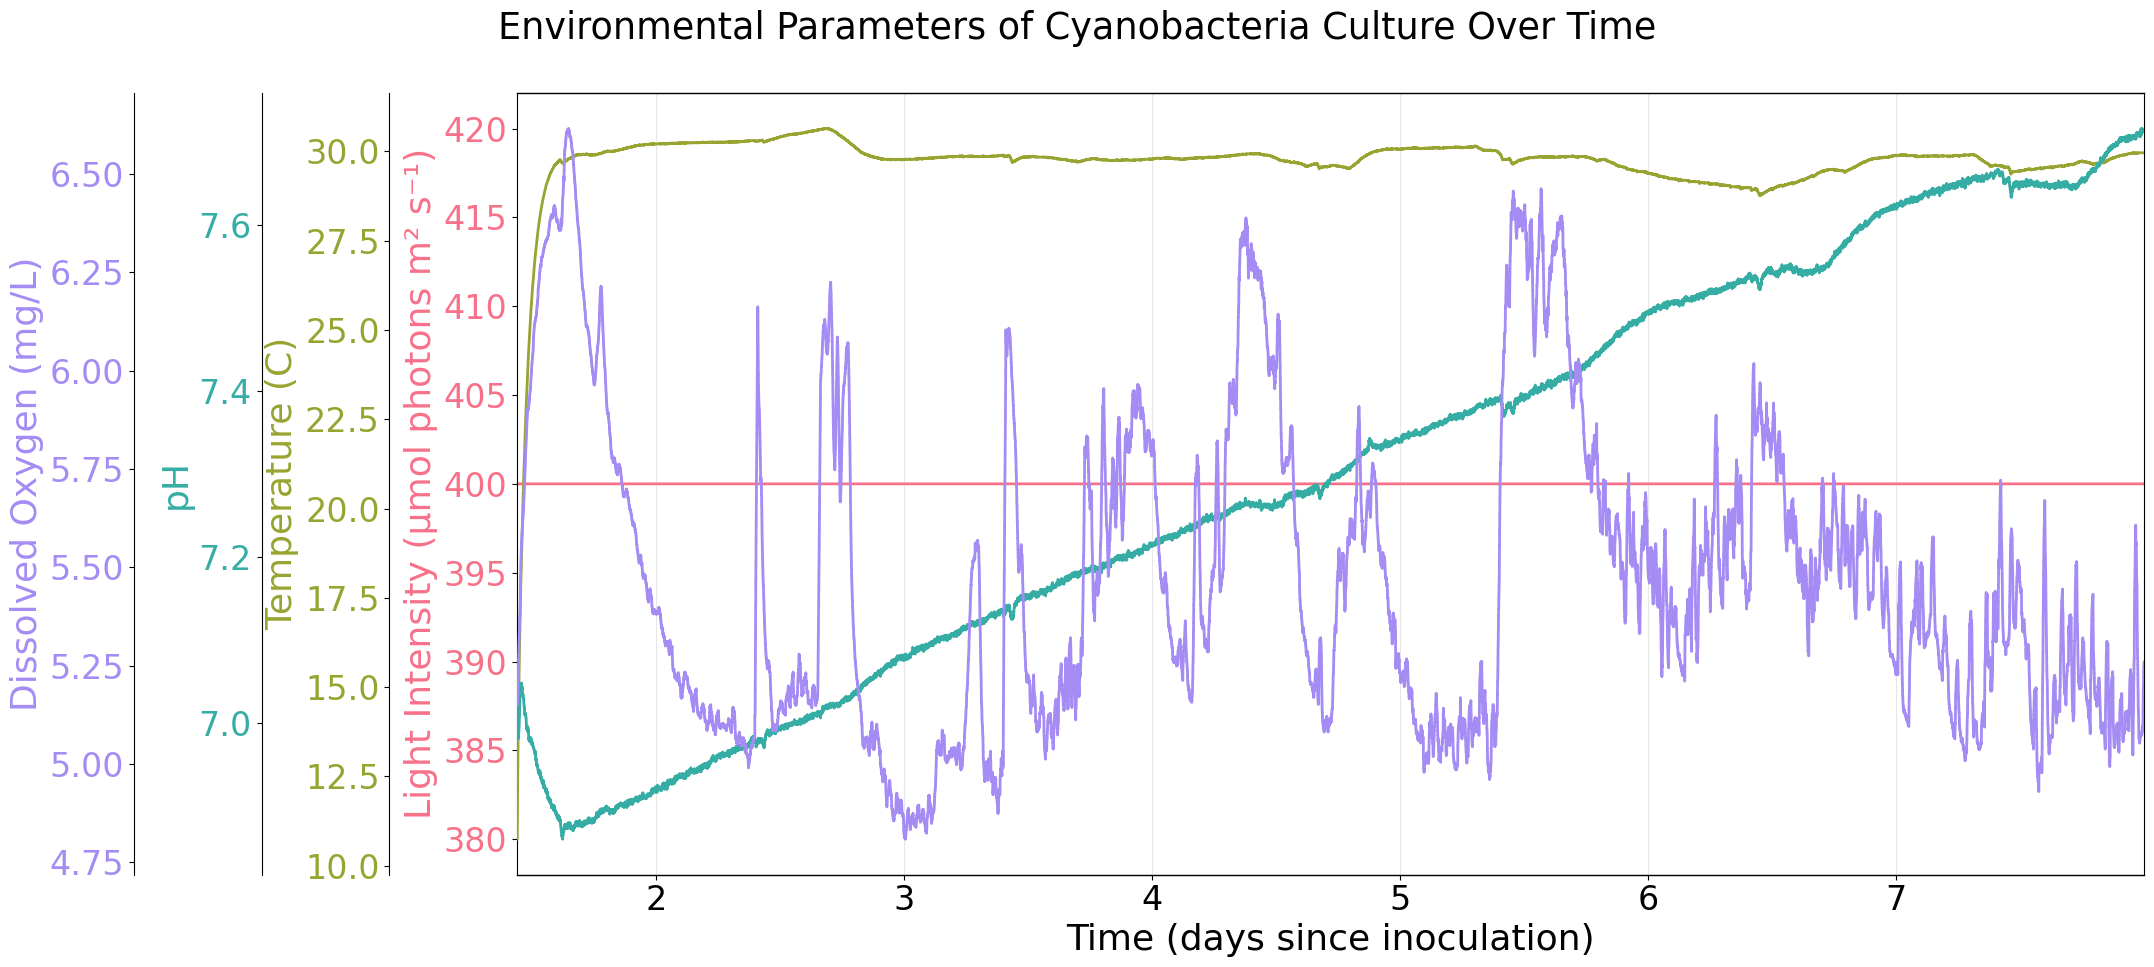

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Global font settings ----------
plt.rcParams.update({
    'font.size': 22,       # base font size
    'axes.titlesize': 30,  # figure/axes titles
    'axes.labelsize': 26,  # x and y labels
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'legend.fontsize': 22
})
# ------------------------------------------

# 1. Prepare the data
lineplot_data = df_combined[[
    'unixtime',
    'Light Intensity (μmol photons m² s⁻¹)',
    'Temperature (C)',
    'pH',
    'Dissolved Oxygen (mg/L)',
]].copy()

# 2. Optional downsampling
for col in ['Light Intensity (μmol photons m² s⁻¹)', 'Temperature (C)', 'pH', 'Dissolved Oxygen (mg/L)']:
    if col in lineplot_data:
        s = lineplot_data[col]
        ds = pd.Series(np.nan, index=s.index, dtype=s.dtype)
        ds.iloc[::50] = s.iloc[::50]
        lineplot_data[col] = ds

lineplot_data = lineplot_data.dropna(how='all')

# 3. Convert unixtime → datetime index, add timestamp & day numbers
lineplot_data['timestamp'] = pd.to_datetime(lineplot_data['unixtime'], unit='s')
lineplot_data = lineplot_data.set_index('timestamp')
lineplot_data['day_number'] = (
    lineplot_data.index.floor('D') - lineplot_data.index.floor('D')[0]
).days + 1
lineplot_data = lineplot_data.drop(columns=['unixtime'])

lineplot_data = lineplot_data[lineplot_data['day_number'] <= 7]

# --- NEW: Apply a moving average to smooth the Dissolved Oxygen data ---
window_size = 1000
lineplot_data['Dissolved Oxygen (mg/L)'] = (
    lineplot_data['Dissolved Oxygen (mg/L)'].rolling(window=window_size, min_periods=1).mean()
)

# 4. Choose which columns to plot
columns_to_plot = [c for c in lineplot_data.columns if c not in ['day_number']]

# 5. Set up the figure
fig, ax1 = plt.subplots(figsize=(22, 10))
palette = sns.color_palette("husl", len(columns_to_plot))

# 6. Plot the first variable
ax1.set_xlabel('Time (days since inoculation)')
ax1.set_ylabel(columns_to_plot[0], color=palette[0])
sns.lineplot(
    data=lineplot_data.dropna(subset=[columns_to_plot[0]]),
    x='timestamp',
    y=columns_to_plot[0],
    ax=ax1,
    color=palette[0],
    linewidth=2,
    legend=False
)
ax1.tick_params(axis='y', labelcolor=palette[0])
ax1.grid(True, axis='x', alpha=0.3)

# 7. Customize x‐ticks
start_time = lineplot_data.index.min()
end_time = lineplot_data.index.max()
day_starts = pd.date_range(start=start_time.normalize(), end=end_time.normalize(), freq='D')
if start_time < day_starts[0]:
    day_starts = day_starts.insert(0, start_time)
labels = np.arange(1, len(day_starts) + 1)

ax1.set_xticks(day_starts)
ax1.set_xticklabels(labels)
ax1.set_xlim(start_time, end_time)

# 8. Plot remaining variables on left-offset twin y-axes
for i, col in enumerate(columns_to_plot[1:], start=1):
    ax_new = ax1.twinx()
    color = palette[i]

    ax_new.spines["right"].set_visible(False)
    ax_new.spines["left"].set_visible(True)
    ax_new.spines["left"].set_position(("outward", 92 * i))

    ax_new.yaxis.set_label_position('left')
    ax_new.yaxis.tick_left()

    ax_new.set_ylabel(col, color=color)

    if col == "Optical Density (620 nm - 750 nm)":
        sns.lineplot(
            data=lineplot_data.dropna(subset=[col]),
            x='timestamp',
            y=col,
            ax=ax_new,
            color='purple',
            linewidth=6,
            marker='o',
            markersize=9,
            legend=False
        )
    else:
        sns.lineplot(
            data=lineplot_data.dropna(subset=[col]),
            x='timestamp',
            y=col,
            ax=ax_new,
            color=color,
            linewidth=2,
            legend=False
        )

    ax_new.tick_params(axis='y', labelcolor=color)
    ax_new.grid(False)

# 9. Final touches
fig.suptitle('Environmental Parameters of Cyanobacteria Culture Over Time')
plt.tight_layout()
plt.show()


# Fun little exercise to try and look thru only the columns that have complete data for correlation matrix

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Select the columns we're interested in
correlation_data = df_combined[
    [
        'Light Intensity (μmol photons m² s⁻¹)',
        "Temperature (C)",
        "pH",
        "Dissolved Oxygen (mg/L)",
        "Optical Density (620 nm - 750 nm)",
    ]
]

# Drop rows with any missing values
complete_data = correlation_data.dropna(how="any")
complete_data


,Light Intensity (μmol photons m² s⁻¹),Temperature (C),pH,Dissolved Oxygen (mg/L),Optical Density (620 nm - 750 nm)
11,400,10.81,7.062,5.15,0.200599
3782,400,23.81,6.993,5.92,0.209471
7553,400,27.77,6.943,6.34,0.208260
7554,400,27.77,6.943,6.34,0.208260
11325,400,29.23,6.910,6.36,0.213201
...,...,...,...,...,...
1062164,400,29.80,7.992,5.95,0.612567
1065935,400,29.79,7.993,5.86,0.612232
1069704,400,29.79,7.988,5.49,0.612951
1073473,400,29.79,7.986,5.44,0.613239


Original shape: (1078294, 5), After dropping NAs: (304, 5)


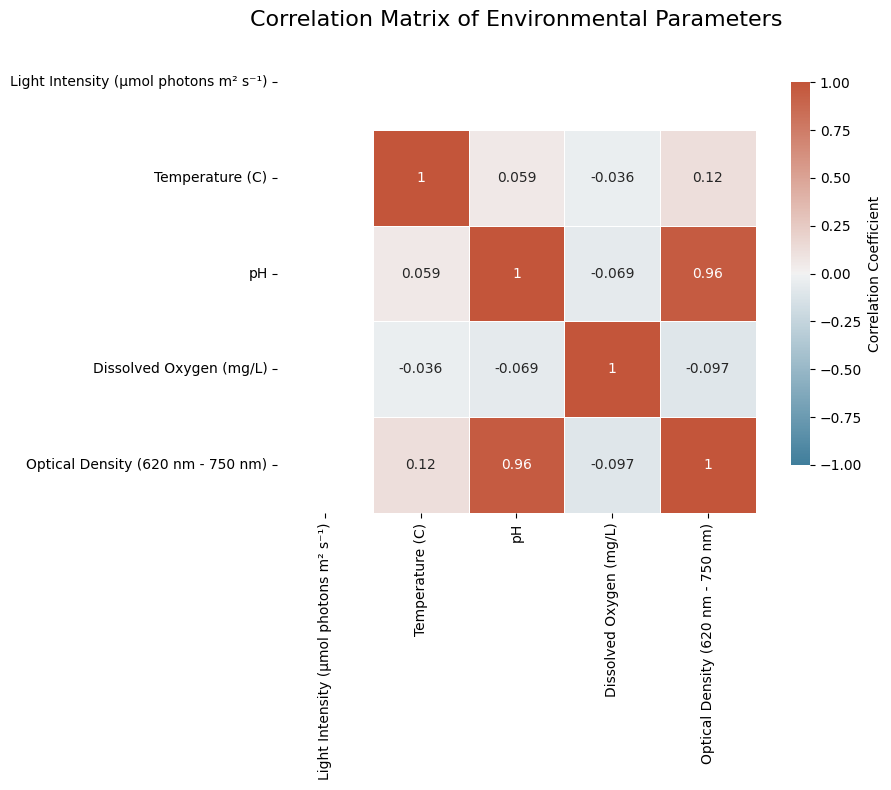


Correlation Matrix:
                                       Light Intensity (μmol photons m² s⁻¹)  \
Light Intensity (μmol photons m² s⁻¹)                                    NaN   
Temperature (C)                                                          NaN   
pH                                                                       NaN   
Dissolved Oxygen (mg/L)                                                  NaN   
Optical Density (620 nm - 750 nm)                                        NaN   

                                       Temperature (C)    pH  \
Light Intensity (μmol photons m² s⁻¹)              NaN   NaN   
Temperature (C)                                   1.00  0.06   
pH                                                0.06  1.00   
Dissolved Oxygen (mg/L)                          -0.04 -0.07   
Optical Density (620 nm - 750 nm)                 0.12  0.96   

                                       Dissolved Oxygen (mg/L)  \
Light Intensity (μmol photons m² s⁻¹)          

<Figure size 1200x1000 with 0 Axes>

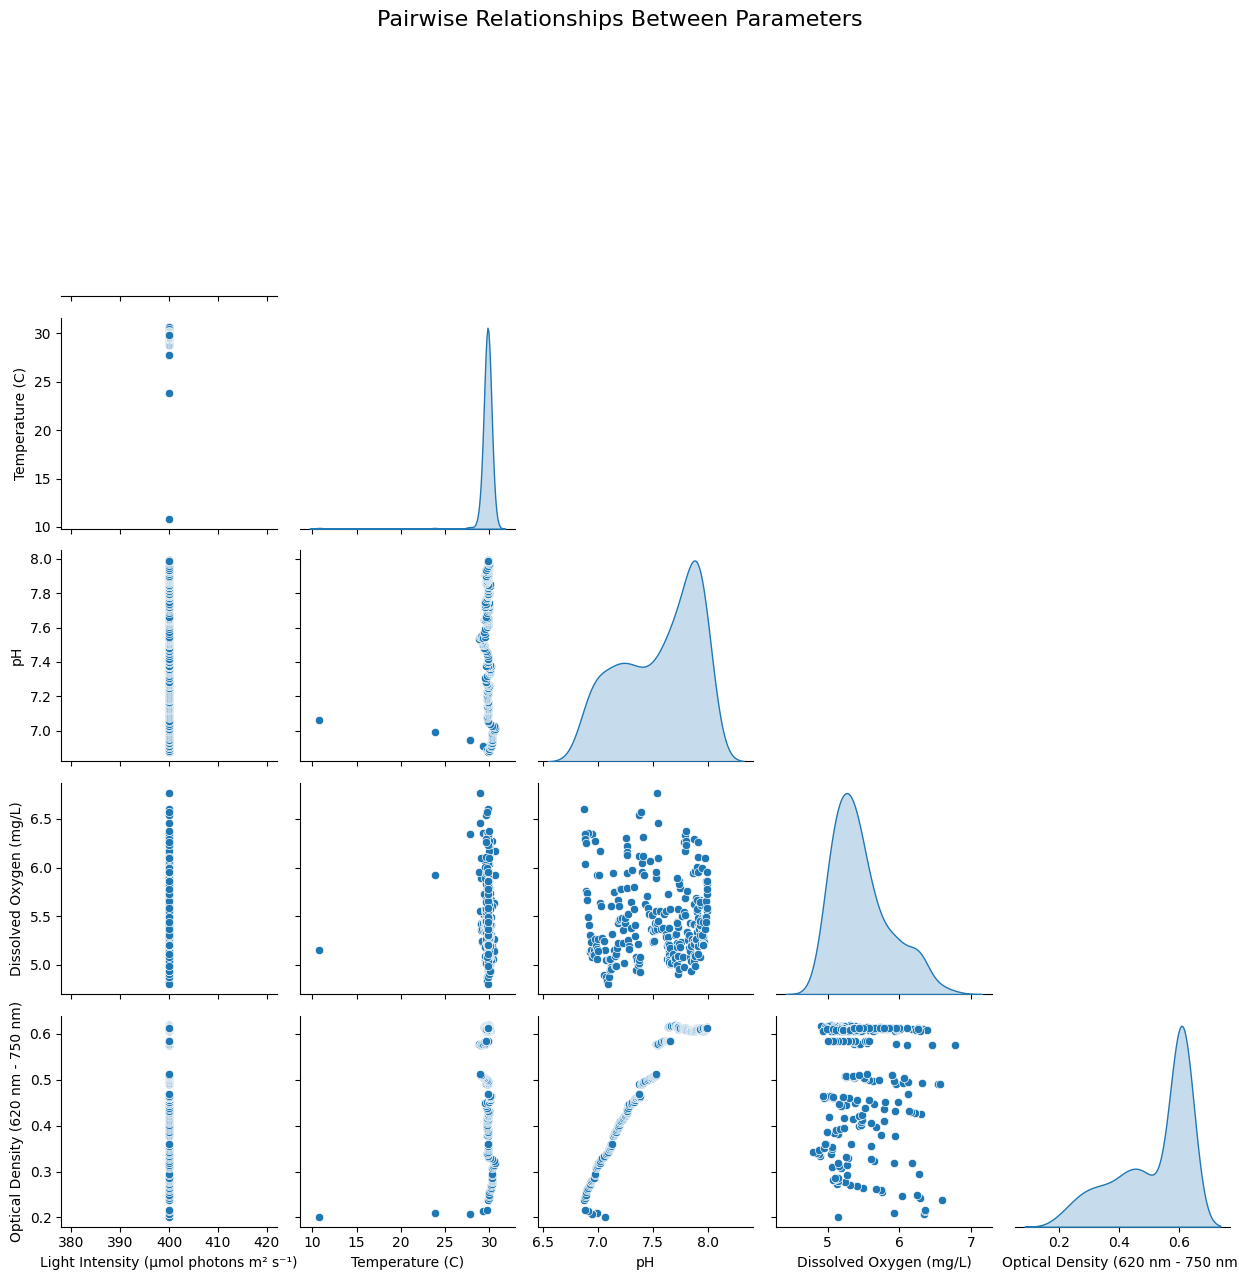

In [20]:
print(f"Original shape: {correlation_data.shape}, After dropping NAs: {complete_data.shape}")

# Calculate the correlation matrix
corr_matrix = complete_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap with formatting
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Create a mask for the upper triangle
cmap = sns.diverging_palette(230, 20, as_cmap=True)  # Use a diverging colormap

# Draw the heatmap
sns.heatmap(
    corr_matrix, 
    annot=True,  # Show correlation values
    cmap=cmap,   # Use our defined colormap
    vmax=1.0,    # Maximum correlation value
    vmin=-1.0,   # Minimum correlation value
    center=0,    # Center the colormap at zero
    square=True, # Make the cells square
    linewidths=.5,
    cbar_kws={"shrink": .8, "label": "Correlation Coefficient"}
)

plt.title('Correlation Matrix of Environmental Parameters', fontsize=16)
plt.tight_layout()
plt.show()

# Let's also look at the actual correlation values
print("\nCorrelation Matrix:")
print(corr_matrix.round(2))

# Additional analysis: descriptive statistics of complete data
print("\nDescriptive Statistics:")
print(complete_data.describe())

# You could also do a pairplot to see both distributions and correlations
plt.figure(figsize=(12, 10))
sns.pairplot(complete_data, diag_kind='kde', corner=True)
plt.suptitle('Pairwise Relationships Between Parameters', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()